# Detect fDOM Plummeting Peaks

## Rules for plummeting peaks

Downward peak where: 
- Base width smaller than threshold 
- Prominence larger than a threshold 
- No corresponding peak in turbidity in a certain range 
- No other downward peaks in certain proximity (this would make the plummeting peak local fluctuation...) 

## Import Tools, Load and Preprocess Data

In [1]:
# Import libraries and data 
import scipy.io as sio
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sn
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pickle
import numpy as np
from scipy.signal import find_peaks
from os.path import dirname, join as pjoin
import datetime
import csv
import math
import Tools.data_processing as dp
import Tools.data_movement as dm 
from Tools.auxiliary_functions import get_candidates, detect_flat_plat, detect_stage_rises

fDOM_data = dm.read_in_preprocessed_timeseries('Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv')
stage_data = dm.read_in_preprocessed_timeseries('Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv')
turb_data = dm.read_in_preprocessed_timeseries('Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv')
stage_data = dp.align_stage_to_fDOM(fDOM_data, stage_data)

## Flip fDOM timeseries to detect plummeting peaks. Get candidate set for plummeting peaks
#### Flipping fDOM is surely inefficient and "peaks" could be detected in the unflipped timeseries

In [2]:
# Flip timeseries 
flipped_fDOM = dp.flip_timeseries(copy.deepcopy(fDOM_data))

# Get fDOM plummeting peak candidate set using scipy find_peaks()
prominence_range = [3,None] # peaks must have at least prominence 3
width_range = [None,10] # peaks cannot have a base width of more than 5
wlen = 100 
distance = 1 
rel_height =.6

# Get list of all peaks that could possibly be plummeting peaks
peaks, props = find_peaks(flipped_fDOM[:,1],
                          height = (None, None),
                          threshold = (None,None),
                          distance = distance,
                          prominence = prominence_range,
                          width = width_range,
                          wlen = wlen,
                          rel_height = rel_height)

# Form candidate set from returned information
cands = [[peak, math.floor(props['left_ips'][i]), math.ceil(props['right_ips'][i]),props['prominences'][i]] for i,peak in enumerate(peaks)]

/var/folders/3w/lhkpgfc505n81_2vs8svxfpr0000gn/T/ipykernel_42244/31462634.py:12: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(flipped_fDOM[:,1],


## Import ground truth labels

In [3]:
# Import and process ground truth
truth_fname = 'Data/labeled_data/ground_truths/fDOM/fDOM_PLP/julian_time/fDOM_PLP_0k-300k.csv'

with open(truth_fname, 'r', newline = '') as f:
    
        reader = csv.reader(f, delimiter = ',')
        # truth entries in form: ['timestamp_of_peak', 'value_of_peak','label_of_peak','idx_of_peak']
        next(reader)
        truths = [[float(row[0]), float(row[1]), row[2], int(row[3])] for row in reader] 
        f.close()   

assert(len(truths) == len(cands))

## Detect turbidity peaks - necessary to distinquish between plummeting peak and interference

In [4]:
turb_peak_params = {'prom' : [6,None],
                    'width': [None, None],
                    'wlen' : 200,
                    'dist' : 1,
                    'rel_h': .6}

# Get fDOM and turb candiate peaks
turb_peaks, _ = get_candidates(turb_data, turb_peak_params)

## Preprocess candidates to avoid repeated work in training

In [5]:
# For each peak, determine how far it is from the closest adjacent peak
proximity_to_adjacent = np.zeros((len(peaks)))

for i in range(len(peaks)):
    x = y = fDOM_data.shape[0] + 1 
    if i > 0: 
        x = abs(peaks[i] - peaks[i-1])
    if i < len(peaks) - 1:
        y = abs(peaks[i] - peaks[i+1])
        
    proximity_to_adjacent[i] = min(x,y)

    
# For each peak, determine how closely it corresponds to the closest turbidity peak for the interference check 

# This is not an efficient way to search, but this operation is performed one time... so no sweat
proximity_to_interference = np.zeros((len(peaks),2))

for i, peak in enumerate(peaks): 
    x = y = fDOM_data.shape[0] + 1 
    for turb_peak in turb_peaks:
        if turb_peak <= peak: 
            x = min(abs(peak-turb_peak),x)
        else:
            y = min(abs(peak-turb_peak),y)
    proximity_to_interference[i,0] = x
    proximity_to_interference[i,1] = y

## Define helper functions and set of training parameters, create training/testing splits

In [6]:
# Define Hyperparameter ranges and training parameters and helper function

iterations = 7000
num_splits = 5

basewidth_range = (1, 10)
prominence_range= (5, 20)

peak_proximity_bounds = (1,20)
turb_interference_bounds = (0,10)


accumulated_test_metrics = {}

accumulated_test_results = {}

accumulated_best_params = {}

accumulated_cfmxs = {}

train_test_split_indices = TimeSeriesSplit(num_splits).split(cands)

def classify_candidate_peaks(peaks, params):
        
    results = []
    for i,peak in enumerate(peaks):
        prominence_condition = peak[3] >= params['min_prominence']
        
        basewidth_condition = abs(peak[1] - peak[2]) <= params['max_basewidth']
        
        interference_condition = (proximity_to_interference[i,0] >= params['interference_x_proximity'] 
            and proximity_to_interference[i,1] >= params['interference_y_proximity'])
        
        proximity_condition = proximity_to_adjacent[i] >= params['proximity_threshold']
        
        if prominence_condition and basewidth_condition and interference_condition and proximity_condition:
            results.append([peak[0], 'PLP'])
        else:
            results.append([peak[0], 'NPLP'])
    return results

def label_positives_negatives(predictions, truths):
    TP = TN = FP = FN = 0
    results = []
    
    for i in range(len(predictions)):
        prediction = predictions[i][1]
        truth = truths[i][2]
        if prediction == 'PLP':
            if truth == 'NPLP':
                FP +=1
                results.append(predictions[i].append('FP'))
            else: 
                TP +=1
                results.append(predictions[i].append('TP'))
        else:
            if truth == 'NPLP':
                TN +=1
                results.append(predictions[i].append('TN'))
            else: 
                FN +=1
                results.append(predictions[i].append('FN'))
        
    return (TP,TN,FP,FN,results)


## Nested Cross Validation Training Loop

Split:  1
Num Pos in Test: 3
Num Pos in Train: 0

Split:  1
Num Pos in Test: 7
Num Pos in Train: 3

 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 
Split: 1  F1: 0.0000 BA: 0.4756  Params: {'max_basewidth': 8, 'min_prominence': 11.384787646187961, 'interference_x_proximity': 8, 'interference_y_proximity': 9, 'proximity_threshold': 9}  TP: 0 TN: 78 FP: 4 FN: 7  Time: 0:00:01.100622
Split:  2
Num Pos in Test: 12
Num Pos in Train: 10

 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 
Split: 2  F1: 0.3333 BA: 0.6147  Params: {'max_basewidth': 5, 'min_prominence': 5.899489268310294, 'interference_x_proximity': 3, 'interference_y_proximity': 4, 'proximity_threshold': 6}  TP: 4 TN: 69 FP: 8 FN: 8  Time: 0:00:01.573396
Split:  3
Num Pos in Test: 3
Num Pos in Train: 22

 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 
Split: 3  F1: 0.0000 BA: 0.43

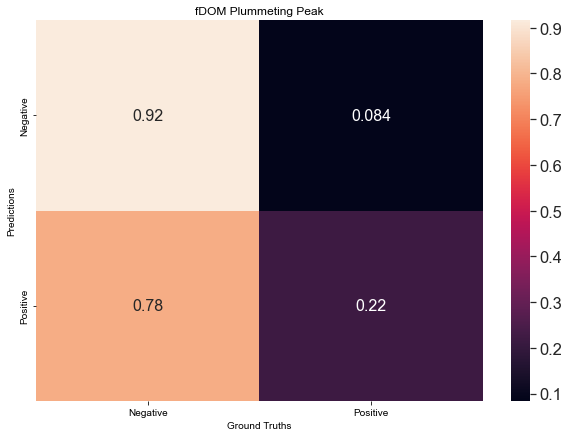

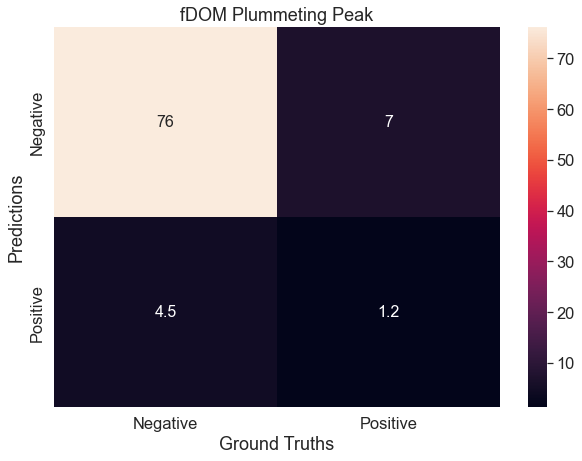

In [7]:
overall_start = datetime.datetime.now()

split = 1
divide_by_zero_errs = 0
for train_val_indices, test_indices in train_test_split_indices:
    X_train, y_train = [cands[i] for i in train_val_indices], [truths[i] for i in train_val_indices]
    X_test, y_test = [cands[i] for i in test_indices], [truths[i] for i in test_indices]

    max_fold_metric = 0 
    max_result = None 

    print("Split: ",split)

    split_start = datetime.datetime.now()
    num_pos_test= len(list(filter(lambda x: x[2] == "PLP", y_test)))
    num_pos_train= len(list(filter(lambda x: x[2] == "PLP", y_train)))

    print(f'Num Pos in Test: {num_pos_test}')
    print(f'Num Pos in Train: {num_pos_train}\n')

    if num_pos_test >= 1 and num_pos_train >= 1: 

        for iteration in range(iterations):

            # Random grid search for hyperparams 
            params = {}

            params['max_basewidth'] = np.random.randint(basewidth_range[0], basewidth_range[1]+1)
            params['min_prominence'] = np.random.uniform(prominence_range[0], prominence_range[1])

            params['interference_x_proximity'] = np.random.randint(turb_interference_bounds[0], turb_interference_bounds[1])
            params['interference_y_proximity'] = np.random.randint(turb_interference_bounds[0], turb_interference_bounds[1])

            params['proximity_threshold']= np.random.randint(peak_proximity_bounds[0], peak_proximity_bounds[1])

            predictions = classify_candidate_peaks(X_train, params)

            TP,TN,FP,FN,results = label_positives_negatives(predictions, y_train)

            TPR = 0 if TP == FN == 0 else TP/(TP + FN)
            TNR = TN/(TN + FP)

            bal_acc = (TPR + TNR)/2 

            f1_score = 0 if TP == FP == FN == 0 else (2 * TP)/((2 * TP) + FP + FN)

            acc = bal_acc
            if iteration and iteration % int(iterations/10) == 0: print(" {}/{} ".format(iteration, iterations), end = "")
            if acc > max_fold_metric: 
                max_fold_metric = acc
                max_result = copy.deepcopy(results)
                best_params = copy.deepcopy(params)

        # Test best parameters on testing data 
        test_predictions = classify_candidate_peaks(X_test, best_params)
        TP,TN,FP,FN,results = label_positives_negatives(test_predictions, y_test)

        cfmx = confusion_matrix([row[2] for row in y_test],[row[1] for row in test_predictions], labels = ['NPLP', 'PLP'])
        accumulated_cfmxs[split] = copy.deepcopy(cfmx)

        TPR = 0 if TP == FN == 0 else TP/(TP + FN)
        TNR = TN/(TN + FP)

        precision = 0 if TP == FP == 0 else TP/(TP + FP)

        bal_acc = (TPR + TNR)/2 

        f1_score = 0 if TP == FP == FN == 0 else (2 * TP)/((2 * TP) + FP + FN)

        print('\nSplit: {}  F1: {:.4f} BA: {:.4f}  Params: {}  TP: {} TN: {} FP: {} FN: {}  Time: {}'.format(split, f1_score, bal_acc, best_params, TP, TN, FP, FN, datetime.datetime.now() - split_start))
        accumulated_test_metrics[split] = {'f1': f1_score, 'ba' : bal_acc, 'tpr': TPR, 'tnr' : TNR, 'precision': precision} # Record test metrics of each split
        accumulated_test_results[split] = copy.deepcopy(results) # Record test results (FP,FN,TP,TN for each datapoint) for each split
        accumulated_best_params[split] = copy.deepcopy(best_params) # Record params uses in testing for each split

        split+=1


print(divide_by_zero_errs)
# Display Resuls 
mean_f1 = 0
mean_ba = 0 
mean_sensitivity = 0
mean_specificity = 0 
mean_precision = 0

for key in accumulated_test_metrics:
    metrics = accumulated_test_metrics[key]
    
    mean_f1+=metrics['f1']
    mean_ba+=metrics['ba']
    mean_sensitivity += metrics['tpr']
    mean_specificity += metrics['tnr']
    mean_precision += metrics['precision']

print("Mean Test F1: ", mean_f1/len(accumulated_test_metrics))
print("Mean Test BA: ", mean_ba/len(accumulated_test_metrics))
print("Mean Test TPR: ", mean_sensitivity/len(accumulated_test_metrics))
print("Mean Test TNR: ", mean_specificity/len(accumulated_test_metrics))
print("Mean Test Precision: ", mean_precision/len(accumulated_test_metrics))

print("Training time: ", datetime.datetime.now() - overall_start)

# Pickle best params
with open('Anomaly_Detection/Experimental_Results/fDOM_PLP/best_params.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_best_params, pck_file)
    pck_file.close()
    
# Pickle test results
with open('Anomaly_Detection/Experimental_Results/fDOM_PLP/test_results.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_test_results, pck_file)
    pck_file.close()

# Pickle test metrics
with open('Anomaly_Detection/Experimental_Results/fDOM_PLP/test_metrics.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_test_metrics, pck_file)
    pck_file.close()
    
mean_cfmx = np.zeros((2,2))
for key in accumulated_cfmxs.keys():
    mean_cfmx += accumulated_cfmxs[key]
mean_cfmx = mean_cfmx / len(accumulated_cfmxs)
print(len(accumulated_cfmxs))
print(mean_cfmx)

plt.figure(figsize = (10,7))
plt.title(label = 'fDOM Plummeting Peak')

sn.set(font_scale = 1.5)
sn.heatmap( pd.DataFrame(mean_cfmx.astype('float') / mean_cfmx.sum(axis=1)[:, np.newaxis],index = ['Negative', 'Positive'], columns = ['Negative','Positive']), annot = True, annot_kws ={"size": 16})
plt.xlabel('Ground Truths')
plt.ylabel('Predictions')
plt.show()

plt.figure(figsize = (10,7))
plt.title(label = 'fDOM Plummeting Peak')

sn.set(font_scale = 1.5)
sn.heatmap( pd.DataFrame(mean_cfmx,index = ['Negative', 'Positive'], columns = ['Negative','Positive']), annot = True, annot_kws ={"size": 16})
plt.xlabel('Ground Truths')
plt.ylabel('Predictions')
plt.show()

## Plot Results

In [8]:
turb_cand_params = {'prom' : [6,None],
                    'width': [None, None],
                    'wlen' : 200,
                    'dist' : 1,
                    'rel_h': .6}

# Get fDOM and turb candiate peaks
turb_peaks, turb_props = get_candidates(turb_data, turb_cand_params)

# Iterate through peaks and turn into short 3 point "events" by flagging the data point to either side of a peak
fDOM_events = []
fDOM_lb = []
fDOM_rb = []

for i,cand in enumerate(cands):
            fDOM_events.append(np.array((flipped_fDOM[cand[0]])))
            fDOM_lb.append(flipped_fDOM[math.floor(cand[1]),0])
            fDOM_rb.append(flipped_fDOM[math.ceil(cand[2]),0])
            
fDOM_lb = list(set(fDOM_lb))
fDOM_lb.sort()
fDOM_rb = list(set(fDOM_rb))
fDOM_rb.sort()

turb_events = []
turb_lb = []
turb_rb = []

for i,peak in enumerate(turb_peaks):
            turb_events.append(np.array((turb_data[peak])))
            turb_lb.append(turb_data[math.floor(turb_props['left_ips'][i]),0])
            turb_rb.append(turb_data[math.ceil(turb_props['right_ips'][i]),0])
            
turb_lb = list(set(turb_lb))
turb_lb.sort()
turb_rb = list(set(turb_rb))
turb_rb.sort()            

fDOM_merged = dp.merge_data(flipped_fDOM, fDOM_events, 'intf', '')
turb_merged = dp.merge_data(turb_data, turb_events, 't_opp', '')

fDOM_merged = dp.merge_additional_data(fDOM_merged, fDOM_lb, 'left_base')
fDOM_merged = dp.merge_additional_data(fDOM_merged, fDOM_rb, 'right_base')

turb_merged = dp.merge_additional_data(turb_merged, turb_lb, 'left_base')
turb_merged = dp.merge_additional_data(turb_merged, turb_rb, 'right_base')


stage_data_merged = dp.merge_data(stage_data, [], '','')

dm.write_data_to_trainset(fDOM_merged,
                          stage_data_merged,
                          turb_merged,
                          'Data/temp_plotting/fDOM_plum_200k-300k.csv',
                          True,
                          True,
                          200000,
                          300000)